<a href="https://colab.research.google.com/github/ARPRAHMAN/AI_Problems/blob/main/AI_project_6168.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# =========================================
# 1. Imports
# =========================================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# -----------------------------
# 2. Dataset Load (existing)
# -----------------------------
df = pd.read_csv('/content/drive/MyDrive/AI_dataset/Copy of Bangla_news (1).csv')

print("Columns:", df.columns.tolist())

# 🔴 CHANGE THESE BASED ON YOUR CSV
df.rename(columns={
    'news_title': 'title',
    'news_content': 'content',
    'category': 'category'
}, inplace=True)

Columns: ['title', 'published_date', 'reporter', 'category', 'url', 'content']


In [51]:

# =========================================
# 3. Filter ONLY SPORTS NEWS
# =========================================
df = df[df['category'].str.lower() == 'sports']
df = df[['title', 'content']].dropna()

print("Total Sports News:", len(df))

Total Sports News: 2976


In [52]:
# =========================================
# 4. Bangla Text Cleaning
# =========================================
def clean_bangla(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', str(text))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['headline_clean'] = df['title'].apply(clean_bangla)
df['content_clean']  = df['content'].apply(clean_bangla)

In [53]:
# =========================================
# 5. Tokenization
# =========================================
max_text_len = 300
max_headline_len = 30
decoder_seq_len = max_headline_len - 1
vocab_size = 25000

text_tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
head_tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

text_tokenizer.fit_on_texts(df['content_clean'])
head_tokenizer.fit_on_texts(df['headline_clean'])

X_seq = text_tokenizer.texts_to_sequences(df['content_clean'])
Y_seq = head_tokenizer.texts_to_sequences(df['headline_clean'])

X = pad_sequences(X_seq, maxlen=max_text_len, padding='post')
Y = pad_sequences(Y_seq, maxlen=max_headline_len, padding='post')


In [54]:
# =========================================
# 6. Train–Validation Split
# =========================================
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [55]:
# =========================================
# 7. Seq2Seq Model (FIXED SHAPES)
# =========================================
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(vocab_size, latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(decoder_seq_len,))
dec_emb_layer = Embedding(vocab_size, latent_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 300, 256)  │  6,400,000 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 29, 256)   │  6,400,000 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 256),     │    525,312 │ embedding_9[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 29, 256), │    525,312 │ embedding_10[0][… │
│                     │ (None, 256),      │            │ lstm_9[0][1],     │
│                     │ (None, 256)]      │            │ lstm_9[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 29, 25000) │  6,425,000 │ lstm_10[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,275,624 (77.35 MB)

 Trainable params: 20,275,624 (77.35 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
print(model.input_shape)

[(None, 300), (None, 29)]


In [57]:
# =========================================
# 8. Training (NO EarlyStopping)
# =========================================
history = model.fit(
    [X_train, Y_train[:, :-1]],
    Y_train[:, 1:].reshape(
        Y_train.shape[0],
        Y_train.shape[1] - 1,
        1
    ),
    validation_data=(
        [X_val, Y_val[:, :-1]],
        Y_val[:, 1:].reshape(
            Y_val.shape[0],
            Y_val.shape[1] - 1,
            1
        )
    ),
    epochs=10,
    batch_size=64
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 7.1355 - val_loss: 2.0549
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 1.7924 - val_loss: 1.7638
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 1.6273 - val_loss: 1.7379
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 1.5634 - val_loss: 1.7273
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 1.5443 - val_loss: 1.7223
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 1.5255 - val_loss: 1.7166
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 1.4996 - val_loss: 1.7157
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 1.4816 - val_loss: 1.7175
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 1.4821 - val_loss: 1.7122
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 1.4459 - val_loss: 1.7169


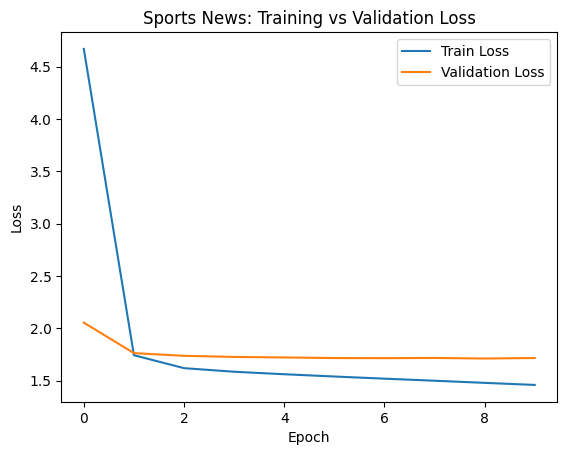

In [62]:
# =========================================
# 9. Loss Graph
# =========================================
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Sports News: Training vs Validation Loss')
plt.show()

In [63]:
# =========================================
# 10. Inference Models (Prediction)
# =========================================
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=decoder_states_inputs
)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

reverse_word_index = head_tokenizer.index_word
start_token = head_tokenizer.word_index['<OOV>']

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token

    decoded_words = []

    for _ in range(decoder_seq_len):
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value
        )

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_word_index.get(sampled_token_index, '')

        if sampled_word == '':
            break

        decoded_words.append(sampled_word)

        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ' '.join(decoded_words)


In [64]:
# =========================================
# 11. Test Prediction
# =========================================
i = 5
print("\nOriginal Sports News:\n", df['content'].iloc[i])
print("\nOriginal Headline:\n", df['title'].iloc[i])
print("\nPredicted Headline:\n", decode_sequence(X[i:i+1]))


Original Sports News:
 ছবি: সংগৃহীত রিয়াল মাদ্রিদ বনাম বার্সেলোনা ম্যাচকে বলা হয় ‘এল ক্লাসিকো’। আন্তর্জাতিক ফুটবলে ক্লাব পর্যায়ে সবচেয়ে বড় দ্বৈরথ এই ম্যাচ। লা লিগায় প্রতি মৌসুমে অন্তত দুই এল ক্লাসিকোর দেখা মেলে। এর বাইরে বিভিন্ন কাপ টুর্নামেন্টেও দেখা হয়ে যায় রিয়াল-বার্সার। তবে এবার মৌসুম শুরুর আগেই দেখা মিলবে এল ক্লাসিকোর। নতুন মৌসুম শুরুর আগে তিনটি প্রীতি ম্যাচ খেলার কথা স্প্যানিশ ক্লাব বার্সেলোনার। এর মধ্যে রিয়াল মাদ্রিদের বিপক্ষেও একটি ম্যাচ রয়েছে।

Original Headline:
 মৌসুম শুরুর আগেই দেখা যাবে ‘এল ক্ল্যাসিকো’
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Predicted Headline:
 বিপক্ষে বিপক্ষে বিপক্ষে


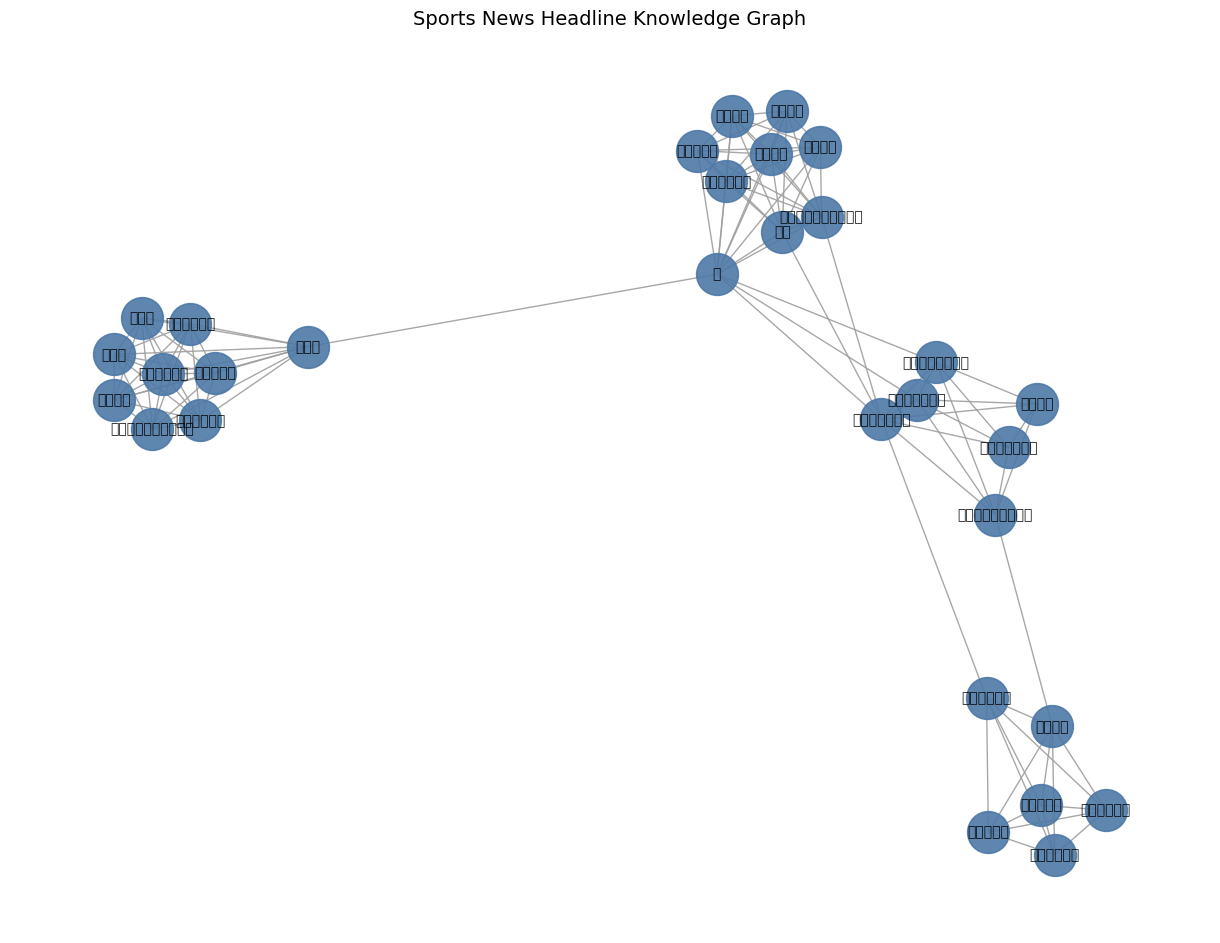

In [74]:
# =========================================
# 12. Knowledge Graph (Sports Headlines)
# =========================================
G = nx.Graph()

for headline in df['headline_clean'].head(400):
    words = headline.split()
    for i in range(len(words)):
        for j in range(i + 1, len(words)):
            G.add_edge(words[i], words[j])

H = G.subgraph(list(G.nodes())[:30])

plt.figure(figsize=(12, 9))

pos = nx.spring_layout(H, seed=42)

nx.draw(
    H,
    pos,
    with_labels=True,
    node_size=900,
    node_color="#4E79A7",      # professional blue
    edge_color="#9E9E9E",      # soft gray
    font_size=10,
    font_color="black",
    linewidths=1.2,
    alpha=0.9
)

plt.title(
    "Sports News Headline Knowledge Graph",
    fontsize=14
)
plt.axis("off")
plt.show()
